In [1]:
import os
import glob
import random
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler

import torchvision.transforms as transforms
import segmentation_models_pytorch as smp

In [2]:
class Unfold(object):
    def __init__(self, crop_size, stride):
        self.crop_size = crop_size
        self.stride = stride
        
    def __call__(self, image):
        n_channels = image.shape[0]
        image = image \
            .unfold(1, self.crop_size, self.stride) \
            .unfold(2, self.crop_size, self.stride)
        image = image.permute(1,2,0,3,4)
        if n_channels == 1:
            image = image.reshape(-1, self.crop_size, self.crop_size)
        else:
            image = image.reshape(-1, n_channels, self.crop_size, self.crop_size)
        
        return image

class RotateAll(object):
    def __call__(self, image):
        transformed_image = [image]
        for i in range(1, 4):
            transformed_image.append(torch.rot90(image, i, [-2, -1]))
        
        transformed_image = torch.cat(transformed_image, 0)
        return transformed_image

class AdjustColor(object):
    def __init__(self, n):
        self.n = n
        self.to_pil_image = transforms.ToPILImage()
        self.tf = transforms.ColorJitter(brightness=(0.1,1.2))
        self.to_tensor = transforms.ToTensor()

    def __call__(self, image):
        transformed_image = [image]
        for i in range(self.n - 1):
            transformed_image.append(self.transform(image))
        
        transformed_image = torch.cat(transformed_image, 0)
        return transformed_image

    def transform(self, image):
        transformed_image = []
        for im in image:
            im = self.to_pil_image(im)
            im = self.tf(im)
            im = self.to_tensor(im)
            transformed_image.append(im)

        transformed_image = torch.stack(transformed_image)

        return transformed_image

class CloneCat(object):
    def __init__(self, n):
        self.n = n
    
    def __call__(self, image):
        return torch.cat([image for _ in range(self.n)])

In [3]:
seed = 42

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
device = torch.device('cuda:1')

import multiprocessing
cpu_count = multiprocessing.cpu_count()

In [5]:
color2idx = {
    (0, 0, 0): 0,
    (255, 255, 0): 1,
    (150, 80, 0): 2,
    (100, 100, 100): 3,
    (0, 0, 150): 4,
    (0, 255, 0): 5,
    (0, 125, 0): 6,
    (150, 150, 250): 7,
    (255, 255, 255): 8
}

idx2color = { v: k for k, v in color2idx.items() }


def cat_to_rgb(cat_arr):
    arr = np.zeros((*cat_arr.shape[:2], 3), dtype=np.int)
    for i in range(len(arr)):
        for j in range(len(arr[0])):
            if cat_arr[i,j] in idx2color:
                arr[i,j] = idx2color[cat_arr[i,j]]
            else:
                arr[i,j] = (255, 255, 255)
    
    return arr

def rgb_to_cat(rgb_arr):
    arr = np.zeros(rgb_arr.shape[:2], dtype=np.int64)
    for i in range(len(arr)):
        for j in range(len(arr[0])):
            if tuple(rgb_arr[i,j]) in color2idx:
                arr[i,j] = color2idx[tuple(rgb_arr[i,j])]
            else:
                arr[i,j] = 8
        
    return arr

In [6]:
image_dir = './data/sat'
layer_dir = './data/gt'
image_paths = sorted(glob.glob(image_dir+'/*.png'))
layer_paths = sorted(glob.glob(layer_dir+'/*.png'))

In [7]:
len(image_paths)

22

In [8]:
transform_sat = transforms.Compose([
    transforms.ToTensor(),
    Unfold(crop_size=128, stride=64),
    RotateAll(),
    AdjustColor(n=3),
])

transform_gt = transforms.Compose([
    transforms.ToTensor(),
    Unfold(crop_size=128, stride=64),
    RotateAll(),
    CloneCat(n=3)
])

In [9]:
transformed_images = torch.tensor([], dtype=torch.float32)
transformed_layers = torch.tensor([], dtype=torch.int64)
for i in range(len(image_paths)):
    image = Image.open(image_paths[i]).convert('RGB')
    layer = Image.open(layer_paths[i]).convert('RGB')
    layer = rgb_to_cat(np.array(layer))
    transformed_images = torch.cat((transformed_images, transform_sat(image)))
    transformed_layers = torch.cat((transformed_layers, transform_gt(layer)))

In [10]:
trainset = TensorDataset(transformed_images, transformed_layers.type(torch.int64))

In [11]:
from sklearn.model_selection import train_test_split
train_idx, valid_idx = train_test_split(np.arange(len(trainset)), test_size=0.1, random_state=42, shuffle=True)

In [12]:
train_loader = DataLoader(trainset, batch_size=64, sampler=SubsetRandomSampler(train_idx), num_workers=(cpu_count//2))
val_loader = DataLoader(trainset, batch_size=64, sampler=SubsetRandomSampler(valid_idx), num_workers=(cpu_count//2))

In [13]:
trainset[1002][1]

tensor([[8, 8, 8,  ..., 8, 8, 8],
        [8, 8, 8,  ..., 8, 8, 8],
        [8, 8, 8,  ..., 8, 8, 8],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]])

In [14]:
model = smp.Unet('efficientnet-b0', classes=len(color2idx), activation='softmax').to(device)

In [15]:
n_epochs = 20
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor((1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)).to(device))

In [16]:
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for train_x, train_y in train_loader:
        train_x, train_y = train_x.to(device), train_y.to(device)
        
        outputs = model(train_x)
        loss = loss_fn(outputs, train_y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x, val_y = val_x.to(device), val_y.to(device)

            outputs = model(val_x)
            loss = loss_fn(outputs, val_y)
            val_loss += loss.item()

        
    print(f'Train Loss: {train_loss/len(trainset):} .... Validation Loss: {val_loss/len(valid_idx)}')
    

Train Loss: 0.025855060396371064 .... Validation Loss: 0.025793763583758064
Train Loss: 0.022661706197141397 .... Validation Loss: 0.024206725796465118
Train Loss: 0.021631519593775073 .... Validation Loss: 0.023330738668891318
Train Loss: 0.021038351851681666 .... Validation Loss: 0.02306030814093773
Train Loss: 0.0207949963783977 .... Validation Loss: 0.02285178646896825
Train Loss: 0.02062987512410289 .... Validation Loss: 0.022722970897501166
Train Loss: 0.02050731744629767 .... Validation Loss: 0.022627310660551694
Train Loss: 0.020402331017083192 .... Validation Loss: 0.02253996639540701
Train Loss: 0.020326986993202057 .... Validation Loss: 0.022469879982848762
Train Loss: 0.02025730206508829 .... Validation Loss: 0.022439160571756586
Train Loss: 0.020204390343592223 .... Validation Loss: 0.022359370543097806
Train Loss: 0.02014652061944056 .... Validation Loss: 0.022324506140718556
Train Loss: 0.02011013662774956 .... Validation Loss: 0.02227263882103994
Train Loss: 0.020072064

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    Unfold(crop_size=128, stride=128),
])

In [18]:
test_image = np.array(Image.open('./data/sat/Ansan_Photo8.png').convert('RGB'))[:,:,:3]
test_gt = np.array(Image.open('./data/gt/Ansan_Photo8.png').convert('RGB'))[:,:,:3]
transformed_test_image = transform(test_image)

In [19]:
transformed_test_image.shape

torch.Size([64, 3, 128, 128])

In [20]:
testset = TensorDataset(transformed_test_image)
test_loader = DataLoader(testset, batch_size=300)

In [21]:
model.eval()
with torch.no_grad():
    for test_x in test_loader:
        test_x = test_x[0].to(device)
        
        outputs = model(test_x)
        _, pred = outputs.max(1)
        result = pred

In [22]:
result = result.reshape(8,8,128,128)

In [23]:
result = result.permute(0,2,1,3).reshape(1024,1024)

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

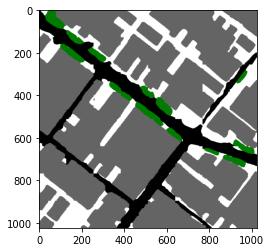

In [25]:
plt.imshow(cat_to_rgb(result.cpu().numpy()))

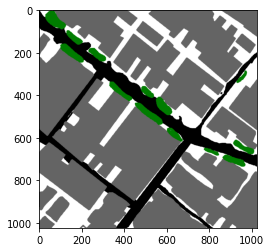

In [26]:
plt.imshow(test_gt)

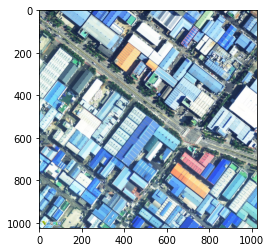

In [27]:
plt.imshow(test_image)

In [28]:
torch.save(model.state_dict(), 'model_bri_0112_copy_2_wei_3.pt')